# Housing Prediction

In [4]:
## To Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
#Loading libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import seaborn as sns
from scipy import stats
from scipy.stats import norm

In [6]:
#loading data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [7]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
print ('The train data has {0} rows and {1} columns'.format(train.shape[0],train.shape[1]))
print ('----------------------------')
print ('The test data has {0} rows and {1} columns'.format(test.shape[0],test.shape[1]))

The train data has 1460 rows and 81 columns
----------------------------
The test data has 1459 rows and 80 columns


### Let's check if the data set has any missing values.

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [10]:
#Another Way to check missing values
train.columns[train.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

### Out of 81 features, 19 features have missing values. Let's check the percentage of missing values in these columns.



In [11]:
#missing value counts in each of these columns
miss = train.isnull().sum()/len(train)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

Electrical      0.000685
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtFinType1    0.025342
BsmtExposure    0.026027
BsmtFinType2    0.026027
GarageCond      0.055479
GarageQual      0.055479
GarageFinish    0.055479
GarageType      0.055479
GarageYrBlt     0.055479
LotFrontage     0.177397
FireplaceQu     0.472603
Fence           0.807534
Alley           0.937671
MiscFeature     0.963014
PoolQC          0.995205
dtype: float64

### We can infer that the variable PoolQC has 99.5% missing values followed by MiscFeature, Alley, and Fence. Let's look at a pretty picture explaining these missing values using a bar plot.

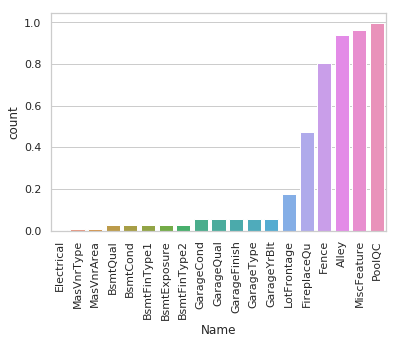

In [12]:
#visualising missing values
miss = miss.to_frame()
miss.columns = ['count']
miss.index.names = ['Name']
miss['Name'] = miss.index

#plot the missing value count
sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Name', y = 'count', data=miss)
plt.xticks(rotation = 90)
plt.show()

### Let's proceed and check the distribution of the target variable.

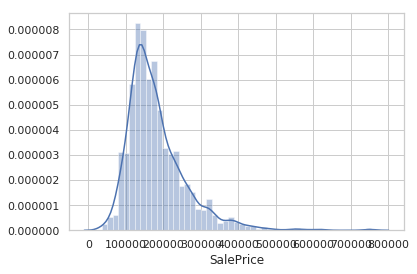

In [13]:
#SalePrice
sns.distplot(train['SalePrice'])

#### We see that the target variable SalePrice has a right-skewed distribution. We'll need to log transform this variable so that it becomes normally distributed. A normally distributed (or close to normal) target variable helps in better modeling the relationship between target and independent variables. In addition, linear algorithms assume constant variance in the error term. Alternatively, we can also confirm this skewed behavior using the skewness metric.

In [14]:
#skewness
print ("The skewness of SalePrice is {}".format(train['SalePrice'].skew()))

The skewness of SalePrice is 1.8828757597682129


### Let's log transform this variable and see if this variable distribution can get any closer to normal.

Skewness is 0.12133506220520406


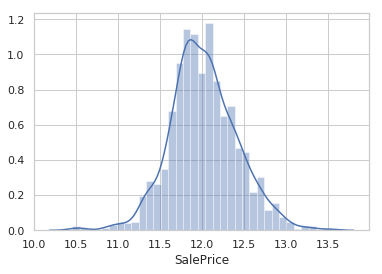

In [15]:
#now transforming the target variable
target = np.log(train['SalePrice'])
print ('Skewness is', target.skew())
sns.distplot(target)

#### As you saw, log transformation of the target variable has helped us fixing its skewed distribution and the new distribution looks closer to normal. Since we have 80 variables, visualizing one by one wouldn't be an astute approach. Instead, we'll look at some variables based on their correlation with the target variable. However, there's a way to plot all variables at once, and we'll look at it as well. Moving forward, we'll separate numeric and categorical variables and explore this data from a different angle.

In [16]:
#separate variables into new data frames
numeric_data = train.select_dtypes(include=[np.number])
cat_data = train.select_dtypes(exclude=[np.number])
print ("There are {} numeric and {} categorical columns in train data".format(numeric_data.shape[1],cat_data.shape[1]))

There are 38 numeric and 43 categorical columns in train data


### There are 38 numeric and 43 categorical columns in the train data. We should remove the Id variable from numeric data.

In [17]:
del numeric_data['Id']

### Now, we are interested to learn about the correlation behavior of numeric variables. Out of 38 variables, I presume some of them must be correlated. If found, we can later remove these correlated variables as they won't provide any useful information to the model.

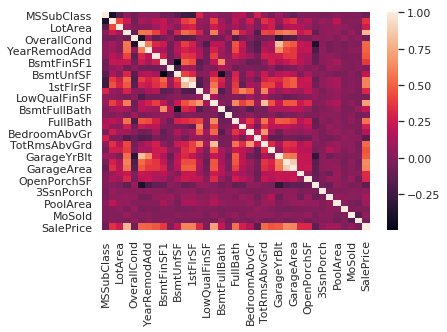

In [18]:
#correlation plot
corr = numeric_data.corr()
sns.heatmap(corr)

### Notice the last row of this map. We can see the correlation of all variables against SalePrice. As you can see, some variables seem to be strongly correlated with the target variable. Here, a numeric correlation score will help us understand the graph better.

In [19]:
print (corr['SalePrice'].sort_values(ascending=False)[:15], '\n') #top 15 values
print ('----------------------')
print (corr['SalePrice'].sort_values(ascending=False)[-5:]) #last 5 values

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64 

----------------------
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


#### Here we see that the OverallQual feature is 79% correlated with the target variable. Overallqual feature refers to the overall material and quality of the materials of the completed house. Well, this make sense as well. People usually consider these parameters for their dream house. In addition, GrLivArea is 70% correlated with the target variable. GrLivArea refers to the living area (in sq ft.) above ground. The following variables show people also care about if the house has a garage, the area of that garage, the size of the basement area, etc.
Let's check the OverallQual variable in detail.

In [20]:
train['OverallQual'].unique()
np.array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

#### The overall quality is measured on a scale of 1 to 10. Hence, we can fairly treat it as an ordinal variable. An ordinal variable has an inherent order. For example, Rank of students in class, data collected on Likert scale, etc. Let's check the median sale price of houses with respect to OverallQual. You might be wondering, “Why median ?” We are using median because the target variable is skewed. A skewed variable has outliers and median is robust to outliers.

We can create such aggregated tables using pandas pivot tables quite easily.

In [21]:
#let's check the mean price per quality and plot it.
pivot = train.pivot_table(index='OverallQual', values='SalePrice', aggfunc=np.median)
pivot.sort_values

<bound method DataFrame.sort_values of              SalePrice
OverallQual           
1                50150
2                60000
3                86250
4               108000
5               133000
6               160000
7               200141
8               269750
9               345000
10              432390>

### Let's plot this table and understand the median behavior using a bar graph.

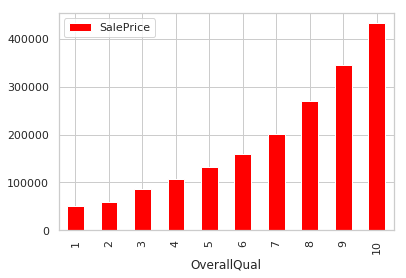

In [22]:
pivot.plot(kind='bar', color='red')

### This behavior is quite normal. As the overall quality of a house increases, its sale price also increases. Let's visualize the next correlated variable GrLivArea and understand their behavior.

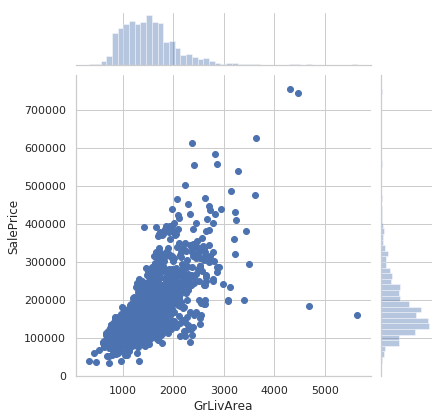

In [23]:
#GrLivArea variable
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'])

#### As seen above, here also we see a direct correlation of living area with sale price. However, we can spot an outlier value GrLivArea > 5000. I've seen outliers play a significant role in spoiling a model's performance. Hence, we'll get rid of it. If you are enjoying this activity, you can visualize other correlated variables as well. Now, we'll move forward and explore categorical features. The simplest way to understand categorical variables is using .describe() command.

In [24]:
cat_data.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


### Let's check the median sale price of a house based on its SaleCondition. SaleCondition explains the condition of sale. Not much information is given about its categories.

In [25]:
sp_pivot = train.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
sp_pivot

,SalePrice
SaleCondition,
Abnorml,130000
AdjLand,104000
Alloca,148145
Family,140500
Normal,160000
Partial,244600


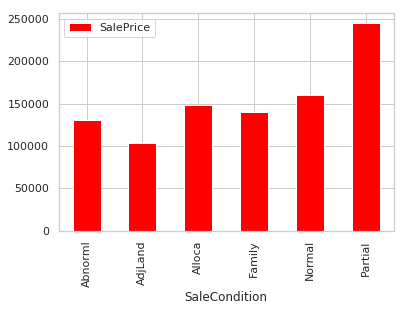

In [26]:
sp_pivot.plot(kind='bar',color='red')

We see that SaleCondition Partial has the highest mean sale price. Though, due to lack of information we can't generate many insights from this data. Moving forward, like we used correlation to determine the influence of numeric features on SalePrice. Similarly, we'll use the ANOVA test to understand the correlation between categorical variables and SalePrice. ANOVA test is a statistical technique used to determine if there exists a significant difference in the mean of groups. For example, let's say we have two variables A and B. Each of these variables has 3 levels (a1,a2,a3 and b1,b2,b3). If the mean of these levels with respect to the target variable is the same, the ANOVA test will capture this behavior and we can safely remove them.

While using ANOVA, our hypothesis is as follows:

Ho - There exists no significant difference between the groups. Ha - There exists a significant difference between the groups.

Now, we'll define a function which calculates p values. From those p values, we'll calculate a disparity score. Higher the disparity score, better the feature in predicting sale price.

<module 'matplotlib.pyplot' from '/home/honey/v_env/lib/python3.6/site-packages/matplotlib/pyplot.py'>

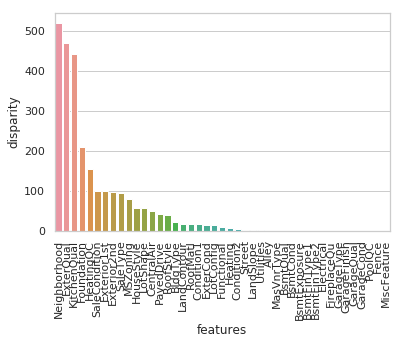

In [27]:
cat = [f for f in train.columns if train.dtypes[f] == 'object']
def anova(frame):
    anv = pd.DataFrame()
    anv['features'] = cat
    pvals = []
    for c in cat:
           samples = []
           for cls in frame[c].unique():
                  s = frame[frame[c] == cls]['SalePrice'].values
                  samples.append(s)
           pval = stats.f_oneway(*samples)[1]
           pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

cat_data['SalePrice'] = train.SalePrice.values
k = anova(cat_data) 
k['disparity'] = np.log(1./k['pval'].values) 
sns.barplot(data=k, x = 'features', y='disparity') 
plt.xticks(rotation=90) 
plt 

Here we see that among all categorical variablesNeighborhoodturned out to be the most important feature followed by ExterQual, KitchenQual, etc. It means that people also consider the goodness of the neighborhood, the quality of the kitchen, the quality of the material used on the exterior walls, etc. Finally, to get a quick glimpse of all variables in a data set, let's plot histograms for all numeric variables to determine if all variables are skewed. For categorical variables, we'll create a boxplot and understand their nature.

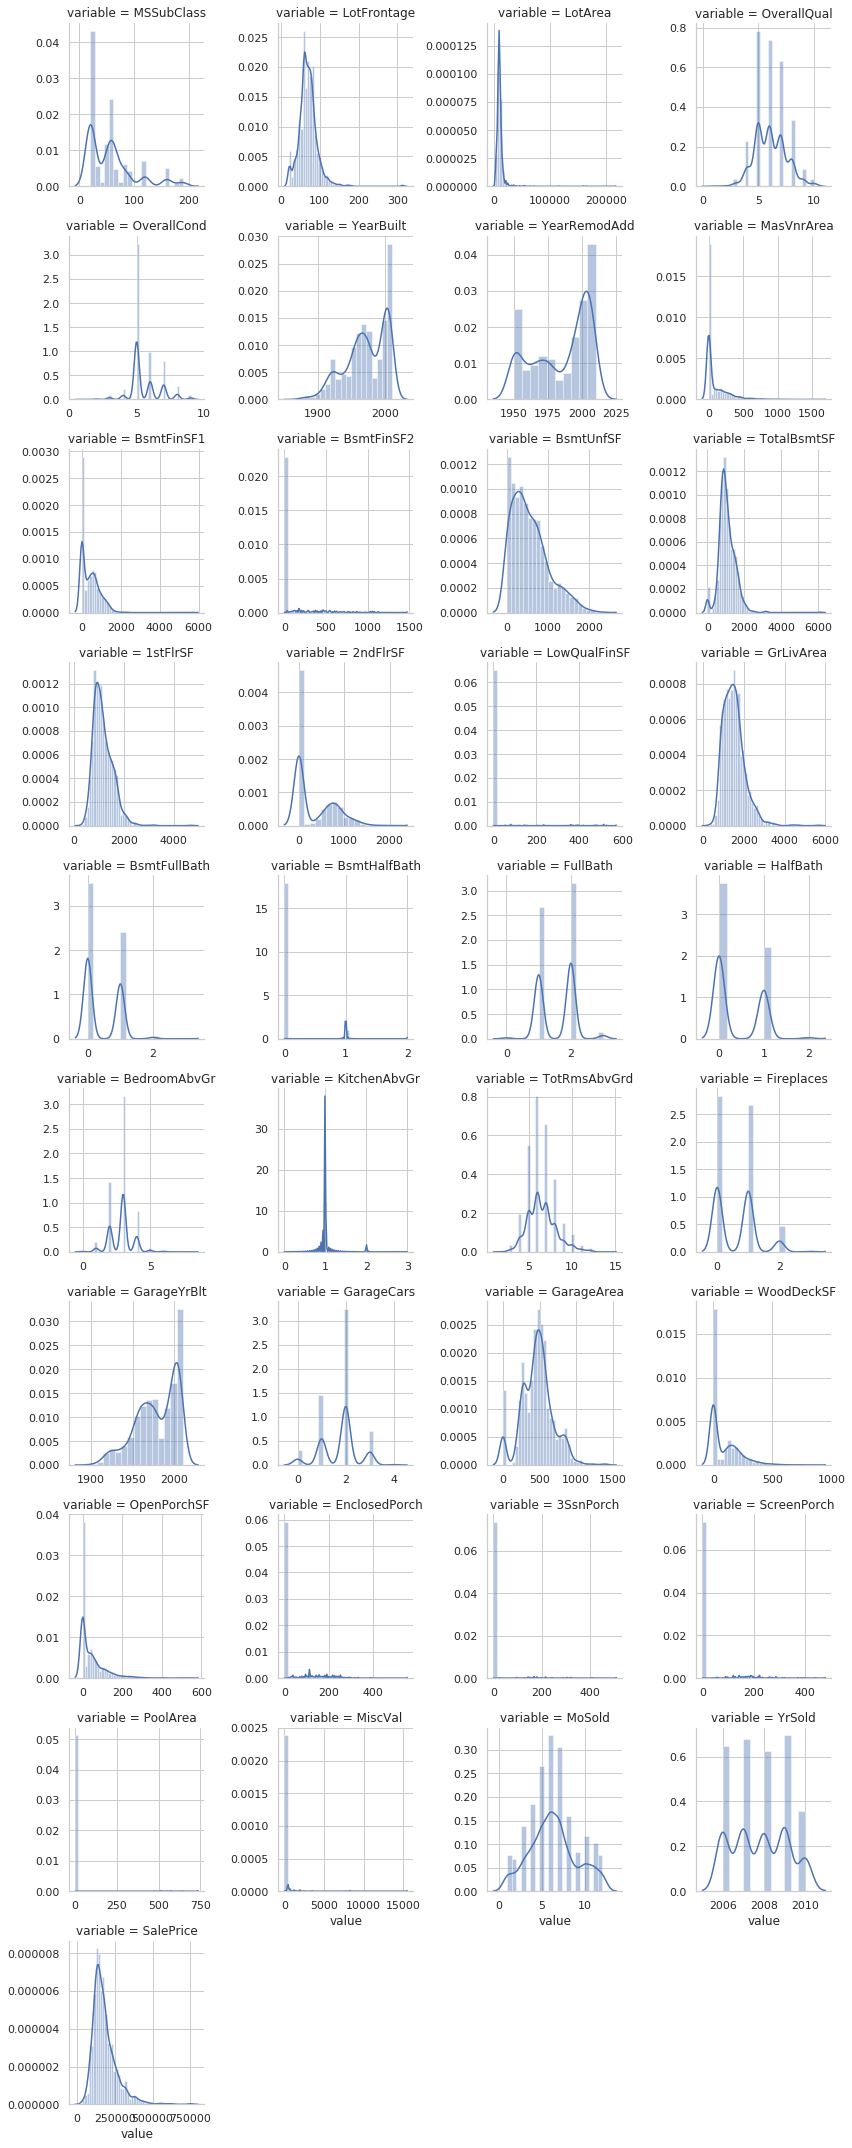

In [28]:
#create numeric plots
num = [f for f in train.columns if train.dtypes[f] != 'object']
num.remove('Id')
nd = pd.melt(train, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

### As you can see, most of the variables are right skewed. We'll have to transform them in the next stage. Now, let's create boxplots for visualizing categorical variables.

/home/honey/v_env/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


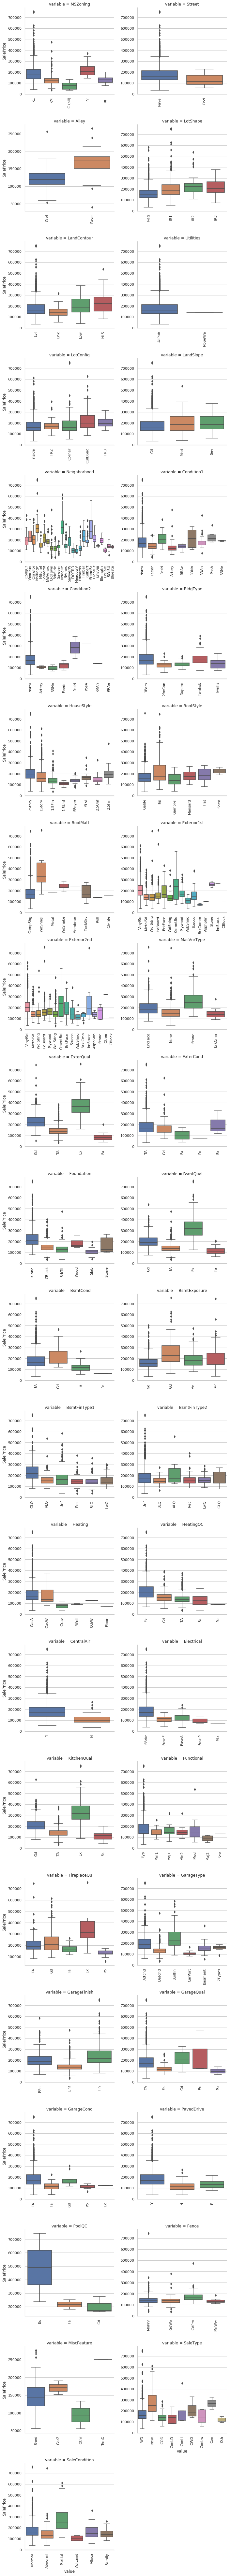

In [29]:
def boxplot(x,y,**kwargs):
            sns.boxplot(x=x,y=y)
            x = plt.xticks(rotation=90)

cat = [f for f in train.columns if train.dtypes[f] == 'object']

p = pd.melt(train, id_vars='SalePrice', value_vars=cat)
g = sns.FacetGrid (p, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, 'value','SalePrice')
g

Here, we can see that most of the variables possess outlier values. It would take us days if we start treating these outlier values one by one. Hence, for now we'll leave them as is and let our algorithm deal with them. As we know, tree-based algorithms are usually robust to outliers.

## Data Pre-Processing

#### In this stage, we'll deal with outlier values, encode variables, impute missing values, and take every possible initiative which can remove inconsistencies from the data set. If you remember, we discovered that the variable GrLivArea has outlier values. Precisely, one point crossed the 4000 mark. Let's remove that:



In [30]:
#removing outliers
train.drop(train[train['GrLivArea'] > 4000].index, inplace=True)
train.shape #removed 4 rows`

(1456, 81)

#### In row 666, in the test data, it was found that information in variables related to 'Garage' (GarageQual, GarageCond, GarageFinish, GarageYrBlt) is missing. Let's impute them using the mode of these respective variables.



In [31]:
#imputing using mode
test.loc[666, 'GarageQual'] = "TA" #stats.mode(test['GarageQual']).mode
test.loc[666, 'GarageCond'] = "TA" #stats.mode(test['GarageCond']).mode
test.loc[666, 'GarageFinish'] = "Unf" #stats.mode(test['GarageFinish']).mode
test.loc[666, 'GarageYrBlt'] = "1980" #np.nanmedian(test['GarageYrBlt'])` 

#### In row 1116, in test data, all garage variables are NA except GarageType. Let's mark it NA as well.

In [32]:
#mark as missing
test.loc[1116, 'GarageType'] = np.nan

#### Now, we'll encode all the categorical variables. This is necessary because most ML algorithms do not accept categorical values, instead they are expected to be converted to numerical. LabelEncoder function from sklearn is used to encode variables. Let's write a function to do this:

In [33]:
#importing function
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def factorize(data, var, fill_na = None):
      if fill_na is not None:
            data[var].fillna(fill_na, inplace=True)
      le.fit(data[var])
      data[var] = le.transform(data[var])
      return data

This function imputes the blank levels with mode values. The mode values are to be entered manually. Now, let's impute the missing values in LotFrontage variable using the median value of LotFrontage by Neighborhood. Such imputation strategies are built during data exploration. I suggest you spend some more time on data exploration. To do this, we should combine our train and test data so that we can modify both the data sets at once. Also, it'll save our time.

In [34]:
#combine the data set
alldata = train.append(test)
alldata.shape

(2915, 81)

The combined data set has 2915 rows and 81 columns. Now, we'll impute the LotFrontage variable.

In [35]:
#impute lotfrontage by median of neighborhood
lot_frontage_by_neighborhood = train['LotFrontage'].groupby(train['Neighborhood'])

for key, group in lot_frontage_by_neighborhood:
                idx = (alldata['Neighborhood'] == key) & (alldata['LotFrontage'].isnull())
                alldata.loc[idx, 'LotFrontage'] = group.median()


Next, in other numeric variables, we'll impute the missing values by zero.

In [36]:
#imputing missing values
alldata["MasVnrArea"].fillna(0, inplace=True)
alldata["BsmtFinSF1"].fillna(0, inplace=True)
alldata["BsmtFinSF2"].fillna(0, inplace=True)
alldata["BsmtUnfSF"].fillna(0, inplace=True)
alldata["TotalBsmtSF"].fillna(0, inplace=True)
alldata["GarageArea"].fillna(0, inplace=True)
alldata["BsmtFullBath"].fillna(0, inplace=True)
alldata["BsmtHalfBath"].fillna(0, inplace=True)
alldata["GarageCars"].fillna(0, inplace=True)
alldata["GarageYrBlt"].fillna(0.0, inplace=True)
alldata["PoolArea"].fillna(0, inplace=True)

Variable names which have 'quality' or 'qual' in their names can be treated as ordinal variables, as mentioned above. Now, we'll convert the categorical variables into ordinal variables. To do this, we'll simply create a dictionary of key-value pairs and map it to the variable in the data set.

In [37]:
qual_dict = {np.nan: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
name = np.array(['ExterQual','PoolQC' ,'ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu', 'GarageQual','GarageCond'])

for i in name:
     alldata[i] = alldata[i].map(qual_dict).astype(int)

alldata["BsmtExposure"] = alldata["BsmtExposure"].map({np.nan: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)

bsmt_fin_dict = {np.nan: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
alldata["BsmtFinType1"] = alldata["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
alldata["BsmtFinType2"] = alldata["BsmtFinType2"].map(bsmt_fin_dict).astype(int)
alldata["Functional"] = alldata["Functional"].map({np.nan: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)

alldata["GarageFinish"] = alldata["GarageFinish"].map({np.nan: 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)
alldata["Fence"] = alldata["Fence"].map({np.nan: 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)

#encoding data
alldata["CentralAir"] = (alldata["CentralAir"] == "Y") * 1.0
varst = np.array(['MSSubClass','LotConfig','Neighborhood','Condition1','BldgType','HouseStyle','RoofStyle','Foundation','SaleCondition'])

for x in varst:
         factorize(alldata, x)

#encode variables and impute missing values
alldata = factorize(alldata, "MSZoning", "RL")
alldata = factorize(alldata, "Exterior1st", "Other")
alldata = factorize(alldata, "Exterior2nd", "Other")
alldata = factorize(alldata, "MasVnrType", "None")
alldata = factorize(alldata, "SaleType", "Oth")

## Feature Engineering

There are no libraries or sets of functions you can use to engineer features. Well, there are some but not as effective. It's majorly a manual task but believe me, it's fun. Feature engineering requires domain knowledge and lots of creative ideas. The ideas for new features usually develop during the data exploration and hypothesis generation stages. The motive of feature engineering is to create new features which can help make predictions better.

As you can also see, there's a massive scope of feature engineering in this data set. Now let's create new features from the given list of 81 features. Make sure you follow this section carefully.

Most categorical variables have near-zero variance distribution. Near-zero variance distribution is when one of the categories in a variable has >90% of the values. We'll create some binary variables depicting the presence or absence of a category. The new features will contain 0 or 1 values. In addition, we'll create some more variables which are self-explanatory with comments.

In [38]:
#creating new variable (1 or 0) based on irregular count levels
#The level with highest count is kept as 1 and rest as 0
alldata["IsRegularLotShape"] = (alldata["LotShape"] == "Reg") * 1
alldata["IsLandLevel"] = (alldata["LandContour"] == "Lvl") * 1
alldata["IsLandSlopeGentle"] = (alldata["LandSlope"] == "Gtl") * 1
alldata["IsElectricalSBrkr"] = (alldata["Electrical"] == "SBrkr") * 1
alldata["IsGarageDetached"] = (alldata["GarageType"] == "Detchd") * 1
alldata["IsPavedDrive"] = (alldata["PavedDrive"] == "Y") * 1
alldata["HasShed"] = (alldata["MiscFeature"] == "Shed") * 1
alldata["Remodeled"] = (alldata["YearRemodAdd"] != alldata["YearBuilt"]) * 1

#Did the modeling happen during the sale year?
alldata["RecentRemodel"] = (alldata["YearRemodAdd"] == alldata["YrSold"]) * 1

# Was this house sold in the year it was built?
alldata["VeryNewHouse"] = (alldata["YearBuilt"] == alldata["YrSold"]) * 1
alldata["Has2ndFloor"] = (alldata["2ndFlrSF"] == 0) * 1
alldata["HasMasVnr"] = (alldata["MasVnrArea"] == 0) * 1
alldata["HasWoodDeck"] = (alldata["WoodDeckSF"] == 0) * 1
alldata["HasOpenPorch"] = (alldata["OpenPorchSF"] == 0) * 1
alldata["HasEnclosedPorch"] = (alldata["EnclosedPorch"] == 0) * 1
alldata["Has3SsnPorch"] = (alldata["3SsnPorch"] == 0) * 1
alldata["HasScreenPorch"] = (alldata["ScreenPorch"] == 0) * 1

#setting levels with high count as 1 and the rest as 0
#you can check for them using the value_counts function
alldata["HighSeason"] = alldata["MoSold"].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})
alldata["NewerDwelling"] = alldata["MSSubClass"].replace({20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})

Now, let's check the number of resultant columns.

In [39]:
alldata.shape

(2915, 100)

Now, we have 100 features in the data. It means we create 19 more columns. Let's continue and create some more features. Once again, we'll combine the original train and test files to create a parallel alldata2 file. This file will have original feature values. We'll use this data as reference to create more features

In [40]:
#create alldata2
alldata2 = train.append(test,sort=False)

alldata["SaleCondition_PriceDown"] = alldata2.SaleCondition.replace({'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

# house completed before sale or not
alldata["BoughtOffPlan"] = alldata2.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
alldata["BadHeating"] = alldata2.HeatingQC.replace({'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})

Just like Garage, we have several columns associated with the area of the property. An interesting variable could be the sum of all areas for a particular house. In addition, we can also create new features based on the year the house built.

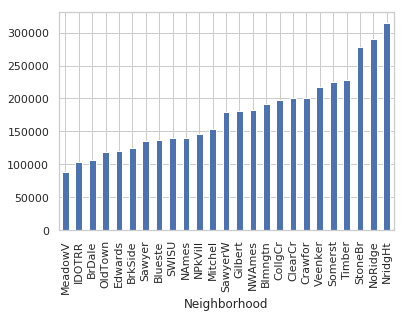

In [41]:
#calculating total area using all area columns
area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF','OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]

alldata["TotalArea"] = alldata[area_cols].sum(axis=1)
alldata["TotalArea1st2nd"] = alldata["1stFlrSF"] + alldata["2ndFlrSF"]
alldata["Age"] = 2010 - alldata["YearBuilt"]
alldata["TimeSinceSold"] = 2010 - alldata["YrSold"]
alldata["SeasonSold"] = alldata["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
alldata["YearsSinceRemodel"] = alldata["YrSold"] - alldata["YearRemodAdd"]

# Simplifications of existing features into bad/average/good based on counts
alldata["SimplOverallQual"] = alldata.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
alldata["SimplOverallCond"] = alldata.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
alldata["SimplPoolQC"] = alldata.PoolQC.replace({1 : 1, 2 : 1, 3 : 2, 4 : 2})
alldata["SimplGarageCond"] = alldata.GarageCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplGarageQual"] = alldata.GarageQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplFireplaceQu"] = alldata.FireplaceQu.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplFireplaceQu"] = alldata.FireplaceQu.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplFunctional"] = alldata.Functional.replace({1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4})
alldata["SimplKitchenQual"] = alldata.KitchenQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplHeatingQC"] = alldata.HeatingQC.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplBsmtFinType1"] = alldata.BsmtFinType1.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
alldata["SimplBsmtFinType2"] = alldata.BsmtFinType2.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
alldata["SimplBsmtCond"] = alldata.BsmtCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplBsmtQual"] = alldata.BsmtQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplExterCond"] = alldata.ExterCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
alldata["SimplExterQual"] = alldata.ExterQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})

#grouping neighborhood variable based on this plot
train['SalePrice'].groupby(train['Neighborhood']).median().sort_values().plot(kind='bar')

The graph above gives us a good hint on how to combine levels of the neighborhood variable into fewer levels. We can combine bars of somewhat equal height in one category. To do this, we'll simply create a dictionary and map it with variable values.

In [42]:
neighborhood_map = {"MeadowV" : 0, "IDOTRR" : 1, "BrDale" : 1, "OldTown" : 1, "Edwards" : 1, "BrkSide" : 1, "Sawyer" : 1, "Blueste" : 1, "SWISU" : 2, "NAmes" : 2, "NPkVill" : 2, "Mitchel" : 2, "SawyerW" : 2, "Gilbert" : 2, "NWAmes" : 2, "Blmngtn" : 2, "CollgCr" : 2, "ClearCr" : 3, "Crawfor" : 3, "Veenker" : 3, "Somerst" : 3, "Timber" : 3, "StoneBr" : 4, "NoRidge" : 4, "NridgHt" : 4}

alldata['NeighborhoodBin'] = alldata2['Neighborhood'].map(neighborhood_map)
alldata.loc[alldata2.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
alldata.loc[alldata2.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
alldata["Neighborhood_Good"].fillna(0, inplace=True)
alldata["SaleCondition_PriceDown"] = alldata2.SaleCondition.replace({'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

# House completed before sale or not
alldata["BoughtOffPlan"] = alldata2.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
alldata["BadHeating"] = alldata2.HeatingQC.replace({'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})
alldata.shape

(2915, 126)

Until this point, we've added 43 new features in the data set. Now, let's split the data into test and train and create some more features.

In [43]:
#create new data
train_new = alldata[alldata['SalePrice'].notnull()]
test_new = alldata[alldata['SalePrice'].isnull()]

print ("Train", train_new.shape)
print ('----------------')
print ("Test", test_new.shape)

Train (1456, 126)
----------------
Test (1459, 126)


Now, we'll transform numeric features and remove their skewness.

In [44]:
#get numeric features
numeric_features = [f for f in train_new.columns if train_new[f].dtype != object]

#transform the numeric features using log(x + 1)
from scipy.stats import skew
skewed = train_new[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
train_new[skewed] = np.log1p(train_new[skewed])
test_new[skewed] = np.log1p(test_new[skewed])
del test_new['SalePrice']

Now, we'll standardize the numeric features.

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_new[numeric_features])
scaled = scaler.transform(train_new[numeric_features])

for i, col in enumerate(numeric_features):
       train_new[col] = scaled[:,i]

numeric_features.remove('SalePrice')
scaled = scaler.fit_transform(test_new[numeric_features])

for i, col in enumerate(numeric_features):
      test_new[col] = scaled[:,i]

/home/honey/v_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/honey/v_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/home/honey/v_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/honey/v_env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Now, we'll one-hot encode the categorical variable. In one-hot encoding, every level of a categorical variable results in a new variable with binary values (0 or 1). We'll write a function to encode categorical variables:

In [46]:
def onehot(onehot_df, df, column_name, fill_na):
       onehot_df[column_name] = df[column_name]
       if fill_na is not None:
            onehot_df[column_name].fillna(fill_na, inplace=True)

       dummies = pd.get_dummies(onehot_df[column_name], prefix="_"+column_name)
       onehot_df = onehot_df.join(dummies)
       onehot_df = onehot_df.drop([column_name], axis=1)
       return onehot_df

def munge_onehot(df):
       onehot_df = pd.DataFrame(index = df.index)

       onehot_df = onehot(onehot_df, df, "MSSubClass", None)
       onehot_df = onehot(onehot_df, df, "MSZoning", "RL")
       onehot_df = onehot(onehot_df, df, "LotConfig", None)
       onehot_df = onehot(onehot_df, df, "Neighborhood", None)
       onehot_df = onehot(onehot_df, df, "Condition1", None)
       onehot_df = onehot(onehot_df, df, "BldgType", None)
       onehot_df = onehot(onehot_df, df, "HouseStyle", None)
       onehot_df = onehot(onehot_df, df, "RoofStyle", None)
       onehot_df = onehot(onehot_df, df, "Exterior1st", "VinylSd")
       onehot_df = onehot(onehot_df, df, "Exterior2nd", "VinylSd")
       onehot_df = onehot(onehot_df, df, "Foundation", None)
       onehot_df = onehot(onehot_df, df, "SaleType", "WD")
       onehot_df = onehot(onehot_df, df, "SaleCondition", "Normal")

       #Fill in missing MasVnrType for rows that do have a MasVnrArea.
       temp_df = df[["MasVnrType", "MasVnrArea"]].copy()
       idx = (df["MasVnrArea"] != 0) & ((df["MasVnrType"] == "None") | (df["MasVnrType"].isnull()))
       temp_df.loc[idx, "MasVnrType"] = "BrkFace"
       onehot_df = onehot(onehot_df, temp_df, "MasVnrType", "None")

       onehot_df = onehot(onehot_df, df, "LotShape", None)
       onehot_df = onehot(onehot_df, df, "LandContour", None)
       onehot_df = onehot(onehot_df, df, "LandSlope", None)
       onehot_df = onehot(onehot_df, df, "Electrical", "SBrkr")
       onehot_df = onehot(onehot_df, df, "GarageType", "None")
       onehot_df = onehot(onehot_df, df, "PavedDrive", None)
       onehot_df = onehot(onehot_df, df, "MiscFeature", "None")
       onehot_df = onehot(onehot_df, df, "Street", None)
       onehot_df = onehot(onehot_df, df, "Alley", "None")
       onehot_df = onehot(onehot_df, df, "Condition2", None)
       onehot_df = onehot(onehot_df, df, "RoofMatl", None)
       onehot_df = onehot(onehot_df, df, "Heating", None)

       # we'll have these as numerical variables too
       onehot_df = onehot(onehot_df, df, "ExterQual", "None")
       onehot_df = onehot(onehot_df, df, "ExterCond", "None")
       onehot_df = onehot(onehot_df, df, "BsmtQual", "None")
       onehot_df = onehot(onehot_df, df, "BsmtCond", "None")
       onehot_df = onehot(onehot_df, df, "HeatingQC", "None")
       onehot_df = onehot(onehot_df, df, "KitchenQual", "TA")
       onehot_df = onehot(onehot_df, df, "FireplaceQu", "None")
       onehot_df = onehot(onehot_df, df, "GarageQual", "None")
       onehot_df = onehot(onehot_df, df, "GarageCond", "None")
       onehot_df = onehot(onehot_df, df, "PoolQC", "None")
       onehot_df = onehot(onehot_df, df, "BsmtExposure", "None")
       onehot_df = onehot(onehot_df, df, "BsmtFinType1", "None")
       onehot_df = onehot(onehot_df, df, "BsmtFinType2", "None")
       onehot_df = onehot(onehot_df, df, "Functional", "Typ")
       onehot_df = onehot(onehot_df, df, "GarageFinish", "None")
       onehot_df = onehot(onehot_df, df, "Fence", "None")
       onehot_df = onehot(onehot_df, df, "MoSold", None)

       # Divide  the years between 1871 and 2010 into slices of 20 years
       year_map = pd.concat(pd.Series("YearBin" + str(i+1), index=range(1871+i*20,1891+i*20))  for i in range(0, 7))
       yearbin_df = pd.DataFrame(index = df.index)
       yearbin_df["GarageYrBltBin"] = df.GarageYrBlt.map(year_map)
       yearbin_df["GarageYrBltBin"].fillna("NoGarage", inplace=True)
       yearbin_df["YearBuiltBin"] = df.YearBuilt.map(year_map)
       yearbin_df["YearRemodAddBin"] = df.YearRemodAdd.map(year_map)

       onehot_df = onehot(onehot_df, yearbin_df, "GarageYrBltBin", None)
       onehot_df = onehot(onehot_df, yearbin_df, "YearBuiltBin", None)
       onehot_df = onehot(onehot_df, yearbin_df, "YearRemodAddBin", None)
       return onehot_df

#create one-hot features
onehot_df = munge_onehot(train)

neighborhood_train = pd.DataFrame(index=train_new.shape)
neighborhood_train['NeighborhoodBin'] = train_new['NeighborhoodBin']
neighborhood_test = pd.DataFrame(index=test_new.shape)
neighborhood_test['NeighborhoodBin'] = test_new['NeighborhoodBin']

onehot_df = onehot(onehot_df, neighborhood_train, 'NeighborhoodBin', None)

Let's add the one-hot variables in our train data set.


In [47]:
train_new = train_new.join(onehot_df) 
train_new.shape

(1456, 433)

This resulted in a whopping 433 columns. Similarly, we will add one-hot variables in test data as well.

In [48]:
#adding one hot features to test
onehot_df_te = munge_onehot(test)
onehot_df_te = onehot(onehot_df_te, neighborhood_test, "NeighborhoodBin", None)
test_new = test_new.join(onehot_df_te)
test_new.shape

(1459, 417)

The difference in number of train and test columns suggests that some new features in the train data aren't available in the test data. Let's remove those variables and keep an equal number of columns in the train and test data.

In [49]:
#dropping some columns from the train data as they are not found in test
drop_cols = ["_Exterior1st_ImStucc", "_Exterior1st_Stone","_Exterior2nd_Other","_HouseStyle_2.5Fin","_RoofMatl_Membran", "_RoofMatl_Metal", "_RoofMatl_Roll", "_Condition2_RRAe", "_Condition2_RRAn", "_Condition2_RRNn", "_Heating_Floor", "_Heating_OthW", "_Electrical_Mix", "_MiscFeature_TenC", "_GarageQual_Ex",  "_PoolQC_Fa"]
train_new.drop(drop_cols, axis=1, inplace=True)
train_new.shape

(1456, 417)

Now, we have an equal number of columns in the train and test data. Here, we'll remove a few more columns which either have lots of zeroes (hence doesn't provide any real information) or aren't available in either of the data sets.

In [50]:
#removing one column missing from train data
test_new.drop(["_MSSubClass_150"], axis=1, inplace=True)

# Drop these columns
drop_cols = ["_Condition2_PosN", # only two are not zero
         "_MSZoning_C (all)",
         "_MSSubClass_160"]

train_new.drop(drop_cols, axis=1, inplace=True)
test_new.drop(drop_cols, axis=1, inplace=True)

Let's transform the target variable and store it in a new array.

In [51]:
#create a label set
label_df = pd.DataFrame(index = train_new.index, columns = ['SalePrice'])
label_df['SalePrice'] = np.log(train['SalePrice'])
print("Training set size:", train_new.shape)
print("Test set size:", test_new.shape)

Training set size: (1456, 414)
Test set size: (1459, 413)


### Dropping Columns 

In [52]:
# Since These Columns don't contain any Numeric Data and ML works on only Numeric Data
Drop_Columns = ['Alley', 'Condition2', 'Electrical', 'GarageType', 'GarageYrBlt', 'Heating', 
                'LandContour','LandSlope', 'LotShape', 'MiscFeature', 'PavedDrive', 'RoofMatl', 'Street', 'Utilities']
Drop_Columns

['Alley',
 'Condition2',
 'Electrical',
 'GarageType',
 'GarageYrBlt',
 'Heating',
 'LandContour',
 'LandSlope',
 'LotShape',
 'MiscFeature',
 'PavedDrive',
 'RoofMatl',
 'Street',
 'Utilities']

###  Drop

In [53]:
train_new.drop(Drop_Columns,axis=1,inplace=True)
test_new.drop(Drop_Columns,axis=1,inplace=True)

### Shape of Data

In [54]:
print(train_new.shape)
print(test_new.shape)

(1456, 400)
(1459, 399)


### Comparing and Checking Features

In [55]:
# Since features don't match in Train and Test Data we will fix these columns
# Features of Training
all_train_cols = list(train_new.columns.values)
all_test_cols = list(test_new.columns.values)

In [56]:
all_train_cols

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BldgType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtQual',
 'BsmtUnfSF',
 'CentralAir',
 'Condition1',
 'EnclosedPorch',
 'ExterCond',
 'ExterQual',
 'Exterior1st',
 'Exterior2nd',
 'Fence',
 'FireplaceQu',
 'Fireplaces',
 'Foundation',
 'FullBath',
 'Functional',
 'GarageArea',
 'GarageCars',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GrLivArea',
 'HalfBath',
 'HeatingQC',
 'HouseStyle',
 'Id',
 'KitchenAbvGr',
 'KitchenQual',
 'LotArea',
 'LotConfig',
 'LotFrontage',
 'LowQualFinSF',
 'MSSubClass',
 'MSZoning',
 'MasVnrArea',
 'MasVnrType',
 'MiscVal',
 'MoSold',
 'Neighborhood',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PoolArea',
 'PoolQC',
 'RoofStyle',
 'SaleCondition',
 'SalePrice',
 'SaleType',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd',
 'YrSold',
 'IsRegularLotSh

In [57]:
all_train_cols

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BldgType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtQual',
 'BsmtUnfSF',
 'CentralAir',
 'Condition1',
 'EnclosedPorch',
 'ExterCond',
 'ExterQual',
 'Exterior1st',
 'Exterior2nd',
 'Fence',
 'FireplaceQu',
 'Fireplaces',
 'Foundation',
 'FullBath',
 'Functional',
 'GarageArea',
 'GarageCars',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GrLivArea',
 'HalfBath',
 'HeatingQC',
 'HouseStyle',
 'Id',
 'KitchenAbvGr',
 'KitchenQual',
 'LotArea',
 'LotConfig',
 'LotFrontage',
 'LowQualFinSF',
 'MSSubClass',
 'MSZoning',
 'MasVnrArea',
 'MasVnrType',
 'MiscVal',
 'MoSold',
 'Neighborhood',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PoolArea',
 'PoolQC',
 'RoofStyle',
 'SaleCondition',
 'SalePrice',
 'SaleType',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd',
 'YrSold',
 'IsRegularLotSh

In [58]:
for i in range(len(all_train_cols)):
    if all_train_cols[i] != all_test_cols[i]:
        print(all_train_cols[i]," and ",all_test_cols[i]," --> ",i)

SalePrice  and  SaleType  -->  58
SaleType  and  ScreenPorch  -->  59
ScreenPorch  and  TotRmsAbvGrd  -->  60
TotRmsAbvGrd  and  TotalBsmtSF  -->  61
TotalBsmtSF  and  WoodDeckSF  -->  62
WoodDeckSF  and  YearBuilt  -->  63
YearBuilt  and  YearRemodAdd  -->  64
YearRemodAdd  and  YrSold  -->  65
YrSold  and  IsRegularLotShape  -->  66
IsRegularLotShape  and  IsLandLevel  -->  67
IsLandLevel  and  IsLandSlopeGentle  -->  68
IsLandSlopeGentle  and  IsElectricalSBrkr  -->  69
IsElectricalSBrkr  and  IsGarageDetached  -->  70
IsGarageDetached  and  IsPavedDrive  -->  71
IsPavedDrive  and  HasShed  -->  72
HasShed  and  Remodeled  -->  73
Remodeled  and  RecentRemodel  -->  74
RecentRemodel  and  VeryNewHouse  -->  75
VeryNewHouse  and  Has2ndFloor  -->  76
Has2ndFloor  and  HasMasVnr  -->  77
HasMasVnr  and  HasWoodDeck  -->  78
HasWoodDeck  and  HasOpenPorch  -->  79
HasOpenPorch  and  HasEnclosedPorch  -->  80
HasEnclosedPorch  and  Has3SsnPorch  -->  81
Has3SsnPorch  and  HasScreenPorch

IndexError: list index out of range

In [59]:
# Here we can see that SalePrice is causung discrepancy in Data
# Moreover we have used SalePrice as label above
# Hence Delete SalePrice
train_new.drop('SalePrice',axis=1,inplace=True)

In [60]:
# Updating the List
all_train_cols = list(train_new.columns.values)
all_test_cols = list(test_new.columns.values)

In [61]:
# Checking After we have Dropped 
for i in range(len(all_train_cols)):
    if all_train_cols[i] != all_test_cols[i]:
        print(all_train_cols[i]," and ",all_test_cols[i]," --> ",i)

_NeighborhoodBin_-0.04760808471778121  and  _NeighborhoodBin_-1.0875767879360991  -->  398


In [62]:
# Columns are Mismatching 
# Renaming one of them to Match

train_new.rename(columns={"_NeighborhoodBin_-0.04760808471778121":"_NeighborhoodBin_-1.0875767879360991"},inplace=True)

In [63]:
# Updating the List
all_train_cols = list(train_new.columns.values)
all_test_cols = list(test_new.columns.values)

In [64]:
# Checking After we have Renamed
for i in range(len(all_train_cols)):
    if all_train_cols[i] != all_test_cols[i]:
        print(all_train_cols[i]," and ",all_test_cols[i]," --> ",i)
else:
    print("Good to go")

Good to go


In [65]:
print(train_new.shape)
print(test_new.shape)

(1456, 399)
(1459, 399)


# Model Training and Evaluation

Since our data is ready, we'll start training models now. We'll use three algorithms: XGBoost, Neural Network and Lasso Regression. Finally, we'll ensemble the models to generate final predictions.

In [66]:
import xgboost as xgb
regr = xgb.XGBRegressor(colsample_bytree=0.2,
                       gamma=0.0,
                       learning_rate=0.05,
                       max_depth=6,
                       min_child_weight=1.5,
                       n_estimators=7200,
                       reg_alpha=0.9,
                       reg_lambda=0.6,
                       subsample=0.2,
                       seed=42,
                       silent=1)

regr.fit(train_new, label_df)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.2, gamma=0.0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=6,
       min_child_weight=1.5, missing=None, n_estimators=7200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0.9,
       reg_lambda=0.6, scale_pos_weight=1, seed=42, silent=1,
       subsample=0.2)

These parameters’ values are derived using cross-validation. To evaluate the model's performance, we'll create a quick RMSE function.

In [67]:
from sklearn.metrics import mean_squared_error
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

# run prediction on training set to get an idea of how well it does
y_pred = regr.predict(train_new)
y_test = label_df
print("XGBoost score on training set: ", rmse(y_test, y_pred))

# make prediction on test set
y_pred_xgb = regr.predict(test_new)

#submit this prediction and get the score
pred1 = pd.DataFrame({'Id': test['Id'], 'SalePrice': np.exp(y_pred_xgb)})
pred1.to_csv('xgbnono.csv', header=True, index=False)

XGBoost score on training set:  0.03783484918515452


In [68]:
from sklearn.linear_model import Lasso

#found this best alpha through cross-validation
best_alpha = 0.00099

regr = Lasso(alpha=best_alpha, max_iter=50000)
regr.fit(train_new, label_df)

# run prediction on the training set to get a rough idea of how well it does
y_pred = regr.predict(train_new)
y_test = label_df
print("Lasso score on training set: ", rmse(y_test, y_pred))

Lasso score on training set:  0.10175440647797632


## On Testing Data

In [69]:
best_alpha = 0.00099

regr = Lasso(alpha=best_alpha, max_iter=50000)
regr.fit(train_new, label_df)

# run prediction on the training set to get a rough idea of how well it does
y_pred_lasso = regr.predict(test_new)

## Using Neural Net

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler

np.random.seed(10)

#create Model
#define base model

# init() keyword was causing problem in function base_model so i removed it
def base_model():
     model = Sequential()
     model.add(Dense(20, input_dim=399, activation='relu'))
     model.add(Dense(10 , activation='relu'))
     model.add(Dense(1))
     model.compile(loss='mean_squared_error', optimizer = 'adam')
     return model

seed = 7
np.random.seed(seed)

scale = StandardScaler()
X_train = scale.fit_transform(train_new)
X_test = scale.fit_transform(test_new)

keras_label = label_df.values
clf = KerasRegressor(build_fn=base_model, nb_epoch=1000, batch_size=5,verbose=0)
clf.fit(X_train,keras_label)

#make predictions and create the submission file 
kpred = clf.predict(X_test) 
kpred = np.exp(kpred)
pred_df = pd.DataFrame(kpred, index=test["Id"], columns=["SalePrice"]) 
pred_df.to_csv('keras1.csv', header=True, index_label='Id') 

/home/honey/v_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/honey/v_env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/honey/v_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/honey/v_env/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [71]:
#simple average
y_pred = (y_pred_xgb + y_pred_lasso) / 2
y_pred = np.exp(y_pred)
pred_df = pd.DataFrame(y_pred, index=test["Id"], columns=["SalePrice"])
pred_df.to_csv('ensemble1.csv', header=True, index_label='Id')